<a href="https://colab.research.google.com/github/MaryamKazemit/GNNE-Stream/blob/main/proposal_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install termcolor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# Define the file paths
input_file = "/content/drive/My Drive/citeseer.cites"  # Update with your file path
output_csv = "/content/drive/My Drive/graph_data.csv"  # Path to save the CSV file

# Read the edges from the text file
edges = []
with open(input_file, "r") as file:
    for line in file:
        node1, node2 = line.strip().split()
        edges.append([node1, node2])

# Convert to DataFrame
df = pd.DataFrame(edges, columns=["Source", "Target"])

# Save to CSV
df.to_csv(output_csv, index=False)

print(f"Graph data saved to {output_csv}")


Graph data saved to /content/drive/My Drive/graph_data.csv


In [5]:
# Load the CSV file
df = pd.read_csv(output_csv)

# Display the first few rows of the DataFrame
print(df.head())


   Source                  Target
0  100157                  100157
1  100157                  364207
2  100157                   38848
3  100157  bradshaw97introduction
4  100157    bylund99coordinating


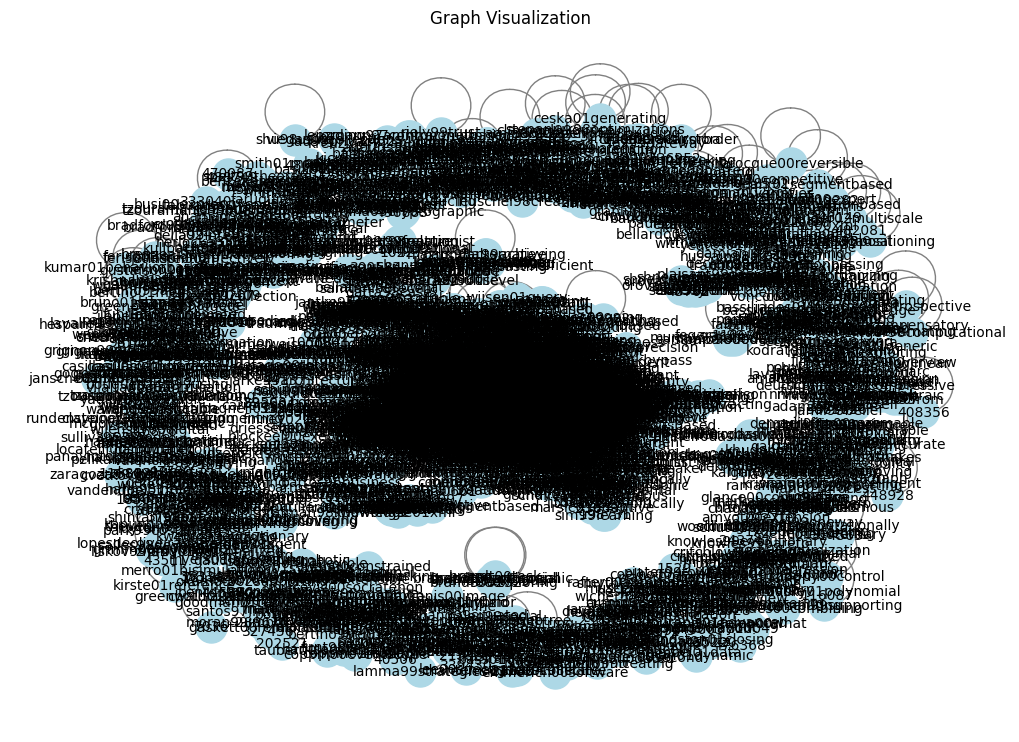

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(df, source="Source", target="Target")

# Draw the graph
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color="lightblue", font_size=10, node_size=500, edge_color="gray")
plt.title("Graph Visualization")
plt.show()


In [7]:
import pandas as pd
file_path = '/content/drive/My Drive/citeseer.cites'
data = pd.read_csv(file_path, sep='\t', header=None, names=['source', 'target'])
data.head()

,source,target
0,100157,100157
1,100157,364207
2,100157,38848
3,100157,bradshaw97introduction
4,100157,bylund99coordinating


In [8]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import time
from collections import deque
from termcolor import colored

# Define the GNN model using PyTorch Geometric
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GNN Ensemble class
class GNNEnsemble:
    def __init__(self, num_models, in_channels, hidden_channels, out_channels):
        self.models = [GNN(in_channels, hidden_channels, out_channels) for _ in range(num_models)]

    def predict(self, data):
        self.models[0].eval()  # Set models to evaluation mode
        outputs = [model(data) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Define the Graph class
class Graph:
    def __init__(self):
        self.adjacency_list = {}
        self.node_mapping = {}
        self.reverse_node_mapping = {}
        self.next_node_index = 0

    def add_node(self, node):
        if node not in self.adjacency_list:
            self.adjacency_list[node] = set()
            self.node_mapping[node] = self.next_node_index
            self.reverse_node_mapping[self.next_node_index] = node
            self.next_node_index += 1

    def add_edge(self, node1, node2):
        self.add_node(node1)
        self.add_node(node2)
        self.adjacency_list[node1].add(node2)
        self.adjacency_list[node2].add(node1)

    def remove_edge(self, node1, node2):
        if node1 in self.adjacency_list and node2 in self.adjacency_list[node1]:
            self.adjacency_list[node1].remove(node2)
        if node2 in self.adjacency_list and node1 in self.adjacency_list[node2]:
            self.adjacency_list[node2].remove(node1)

        if node1 in self.adjacency_list and not self.adjacency_list[node1]:
            del self.adjacency_list[node1]
        if node2 in self.adjacency_list and not self.adjacency_list[node2]:
            del self.adjacency_list[node2]

    def print_graph(self):
        for node, edges in self.adjacency_list.items():
            node_str = colored(f"{node}", "white", "on_blue", attrs=['bold'])
            edges_str = ', '.join(edges)
            print(f"{node_str} -> {edges_str}")

    def to_edge_index(self):
        edges = []
        for node1, neighbors in self.adjacency_list.items():
            for node2 in neighbors:
                edges.append([self.node_mapping[node1], self.node_mapping[node2]])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def get_num_nodes(self):
        return len(self.node_mapping)

# Define the StreamingGraph class
class StreamingGraph:
    def __init__(self, window_size, gnn_ensemble, in_channels):
        self.graph = Graph()
        self.edge_window = deque(maxlen=window_size)
        self.gnn_ensemble = gnn_ensemble
        self.in_channels = in_channels

    def load_initial_data(self, file_path, initial_count):
        with open(file_path, "r") as file:
            count = 0
            for line in file:
                if count >= initial_count:
                    break
                node1, node2 = line.strip().split()
                self.add_edge(node1, node2)
                count += 1

    def simulate_streaming_data(self, file_path, batch_size=10):
        edge_buffer = []
        with open(file_path, "r") as file:
            for line in file:
                node1, node2 = line.strip().split()
                edge_buffer.append((node1, node2))

                if len(edge_buffer) >= batch_size:
                    self.process_edges(edge_buffer)
                    edge_buffer.clear()

        # Process any remaining edges
        if edge_buffer:
            self.process_edges(edge_buffer)

    def process_edges(self, edges):
        for node1, node2 in edges:
            self.add_edge(node1, node2)

        print(colored("Updated Graph:", "yellow", attrs=['bold']))
        self.graph.print_graph()
        print(colored("-" * 50, "yellow", attrs=['bold']))

        edge_index = self.graph.to_edge_index()
        num_nodes = self.graph.get_num_nodes()

        # Ensure that x has features for all nodes referenced in edge_index
        max_index = edge_index.max().item()
        if max_index >= num_nodes:
            num_nodes = max_index + 1

        x = torch.randn((num_nodes, self.in_channels), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index)
        output = self.gnn_ensemble.predict(data)
        print(colored("GNN Ensemble Output:", "green", attrs=['bold']))
        print(output)

    def add_edge(self, node1, node2):
        if len(self.edge_window) == self.edge_window.maxlen:
            oldest_edge = self.edge_window.popleft()
            self.graph.remove_edge(oldest_edge[0], oldest_edge[1])

        self.edge_window.append((node1, node2))
        self.graph.add_edge(node1, node2)

# Main function to run the streaming graph simulation
def main():
    file_path = "/content/drive/My Drive/citeseer.cites"  # Update with your path
    in_channels = 10
    gnn_ensemble = GNNEnsemble(num_models=3, in_channels=in_channels, hidden_channels=16, out_channels=2)

    streaming_graph = StreamingGraph(window_size=5, gnn_ensemble=gnn_ensemble, in_channels=in_channels)

    print(colored("Loading Initial Graph...", "cyan", attrs=['bold']))
    # Load the first 5 edges as the initial graph
    streaming_graph.load_initial_data(file_path, initial_count=5)

    print(colored("Initial Graph:", "yellow", attrs=['bold']))
    streaming_graph.graph.print_graph()
    print(colored("=" * 50, "yellow", attrs=['bold']))

    # Simulate streaming data with the remaining edges
    streaming_graph.simulate_streaming_data(file_path, batch_size=10)

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
thomas00creating -> carson99blobworld
carvalho00hybrid -> carvalho00genetic
carvalho00genetic -> carvalho00hybrid
carver00methodology -> 484682
484682 -> carver00methodology
--------------------------------------------------
GNN Ensemble Output:
tensor([[-1.0280, -0.9350],
        [-1.4004, -0.4537],
        [-0.9644, -0.5685],
        ...,
        [-1.1902, -0.3679],
        [-1.0551, -0.5348],
        [-1.0551, -0.5348]], grad_fn=<MeanBackward1>)
Updated Graph:
cassell00nudge -> 506993, 418446
418446 -> cassell00nudge
506993 -> cassell00nudge
cassell01more -> stocky02conveying, cassell02mack
cassell02mack -> stocky02conveying, cassell01more
stocky02conveying -> cassell02mack, cassell01more
--------------------------------------------------
GNN Ensemble Output:
tensor([[-1.2377, -1.4050],
        [-0.4809, -1.2268],
        [-0.8490, -1.0373],
        ...,
        [-0.7084, -0.7286],
        [-0.7084, -0.7286],
        [-0.7084, -0.72

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import time
from collections import deque

# Define ANSI escape sequences for coloring and formatting
class TextStyles:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    RESET = '\033[0m'
    BACKGROUND_BLUE = '\033[44m'
    BACKGROUND_GREEN = '\033[42m'
    BACKGROUND_YELLOW = '\033[43m'
    BACKGROUND_RED = '\033[41m'

# Define the GNN model using PyTorch Geometric
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GNN Ensemble class
class GNNEnsemble:
    def __init__(self, num_models, in_channels, hidden_channels, out_channels):
        self.models = [GNN(in_channels, hidden_channels, out_channels) for _ in range(num_models)]

    def predict(self, data):
        self.models[0].eval()  # Set models to evaluation mode
        outputs = [model(data) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Define the Graph class
class Graph:
    def __init__(self):
        self.adjacency_list = {}
        self.node_mapping = {}
        self.reverse_node_mapping = {}
        self.next_node_index = 0

    def add_node(self, node):
        if node not in self.adjacency_list:
            self.adjacency_list[node] = set()
            self.node_mapping[node] = self.next_node_index
            self.reverse_node_mapping[self.next_node_index] = node
            self.next_node_index += 1

    def add_edge(self, node1, node2):
        self.add_node(node1)
        self.add_node(node2)
        self.adjacency_list[node1].add(node2)
        self.adjacency_list[node2].add(node1)

    def remove_edge(self, node1, node2):
        if node1 in self.adjacency_list and node2 in self.adjacency_list[node1]:
            self.adjacency_list[node1].remove(node2)
        if node2 in self.adjacency_list and node1 in self.adjacency_list[node2]:
            self.adjacency_list[node2].remove(node1)

        if node1 in self.adjacency_list and not self.adjacency_list[node1]:
            del self.adjacency_list[node1]
        if node2 in self.adjacency_list and not self.adjacency_list[node2]:
            del self.adjacency_list[node2]

    def print_graph(self):
        for node, edges in self.adjacency_list.items():
            node_str = f"{TextStyles.BOLD}{TextStyles.BACKGROUND_BLUE}{node}{TextStyles.RESET}"
            edges_str = ', '.join(edges)
            print(f"{node_str} -> {edges_str}")

    def to_edge_index(self):
        edges = []
        for node1, neighbors in self.adjacency_list.items():
            for node2 in neighbors:
                edges.append([self.node_mapping[node1], self.node_mapping[node2]])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def get_num_nodes(self):
        return len(self.node_mapping)

# Define the StreamingGraph class
class StreamingGraph:
    def __init__(self, window_size, gnn_ensemble, in_channels):
        self.graph = Graph()
        self.edge_window = deque(maxlen=window_size)
        self.gnn_ensemble = gnn_ensemble
        self.in_channels = in_channels

    def load_initial_data(self, file_path, initial_count):
        with open(file_path, "r") as file:
            count = 0
            for line in file:
                if count >= initial_count:
                    break
                node1, node2 = line.strip().split()
                self.add_edge(node1, node2)
                count += 1

    def simulate_streaming_data(self, file_path, batch_size=10):
        edge_buffer = []
        with open(file_path, "r") as file:
            for line in file:
                node1, node2 = line.strip().split()
                edge_buffer.append((node1, node2))

                if len(edge_buffer) >= batch_size:
                    self.process_edges(edge_buffer)
                    edge_buffer.clear()

        # Process any remaining edges
        if edge_buffer:
            self.process_edges(edge_buffer)

    def process_edges(self, edges):
        for node1, node2 in edges:
            self.add_edge(node1, node2)

        print(f"{TextStyles.BOLD}{TextStyles.YELLOW}Updated Graph:{TextStyles.RESET}")
        self.graph.print_graph()
        print(f"{TextStyles.BOLD}{TextStyles.YELLOW}{'-' * 50}{TextStyles.RESET}")

        edge_index = self.graph.to_edge_index()
        num_nodes = self.graph.get_num_nodes()

        # Ensure that x has features for all nodes referenced in edge_index
        max_index = edge_index.max().item()
        if max_index >= num_nodes:
            num_nodes = max_index + 1

        x = torch.randn((num_nodes, self.in_channels), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index)
        output = self.gnn_ensemble.predict(data)
        print(f"{TextStyles.BOLD}{TextStyles.GREEN}GNN Ensemble Output:{TextStyles.RESET}")
        print(output)

    def add_edge(self, node1, node2):
        if len(self.edge_window) == self.edge_window.maxlen:
            oldest_edge = self.edge_window.popleft()
            self.graph.remove_edge(oldest_edge[0], oldest_edge[1])

        self.edge_window.append((node1, node2))
        self.graph.add_edge(node1, node2)

# Main function to run the streaming graph simulation
def main():
    file_path = "/content/drive/My Drive/citeseer.cites"  # Update with your path
    in_channels = 10
    gnn_ensemble = GNNEnsemble(num_models=3, in_channels=in_channels, hidden_channels=16, out_channels=2)

    print(f"{TextStyles.BOLD}{TextStyles.CYAN}Loading Initial Graph...{TextStyles.RESET}")
    # Load the first 5 edges as the initial graph
    streaming_graph = StreamingGraph(window_size=5, gnn_ensemble=gnn_ensemble, in_channels=in_channels)
    streaming_graph.load_initial_data(file_path, initial_count=5)

    print(f"{TextStyles.BOLD}{TextStyles.YELLOW}Initial Graph:{TextStyles.RESET}")
    streaming_graph.graph.print_graph()
    print(f"{TextStyles.BOLD}{TextStyles.YELLOW}{'=' * 50}{TextStyles.RESET}")

    # Simulate streaming data with the remaining edges
    streaming_graph.simulate_streaming_data(file_path, batch_size=10)

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
thomas00creating -> carson99blobworld
carvalho00hybrid -> carvalho00genetic
carvalho00genetic -> carvalho00hybrid
carver00methodology -> 484682
484682 -> carver00methodology
--------------------------------------------------
GNN Ensemble Output:
tensor([[-1.7732, -0.3809],
        [-1.4731, -0.2725],
        [-0.7404, -0.7295],
        ...,
        [-1.0187, -0.5864],
        [-0.9103, -0.5309],
        [-0.9103, -0.5309]], grad_fn=<MeanBackward1>)
Updated Graph:
cassell00nudge -> 506993, 418446
418446 -> cassell00nudge
506993 -> cassell00nudge
cassell01more -> stocky02conveying, cassell02mack
cassell02mack -> stocky02conveying, cassell01more
stocky02conveying -> cassell02mack, cassell01more
--------------------------------------------------
GNN Ensemble Output:
tensor([[-0.5600, -1.0022],
        [-0.3112, -1.5493],
        [-0.6125, -0.9063],
        ...,
        [-0.8494, -0.5841],
        [-0.8494, -0.5841],
        [-0.8494, -0.58